In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#%matplotlib inline
%matplotlib nbagg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cPickle as pickle
import multiprocessing
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/Github/AC297r-Volume-Registration/code')

In [3]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from rotation_3d import tricubic_derivatives,tricubic_interp
from visualize import plot_cost_func
from cost_functions import cf_ssd
from Gauss_Newton import Gauss_Newton, axis_derivatives,print_results,sphere_mask,fourier_filter,get_gradient_P
from conversion import angles_from_q

In [4]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [5]:
oct13_dict_5mm_trans = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_5mm_trans.p','rb'))

In [4]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [7]:
def get_volume(res, rot_ax, rang_id, rot_angle):
    if('10' in res): dict_ = oct13_dict_10
    if('8' in res): dict_ = oct13_dict_8
    if('6_4' in res): dict_ = oct13_dict_6_4
    rad = res_to_rad(res)
    vol = dict_[rot_ax][axes_dict[rot_ax]][ranges[rang_id]][rot_angle]
    vol_filtered = abs(fft.ifftn(fft.ifftshift(sphere_mask(fft.fftshift(fft.fftn(vol)),rad))))
    return sphere_mask(vol_filtered,rad)

In [140]:
#res = str(sys.argv[1])
#dict_ = pickle.load(open('/cluster/tisdall/Diana/reg_code/oct13_dict_%s.p' % res,'rb'))
#axes_dict = pickle.load(open('/cluster/tisdall/Diana/reg_code/axes_dict.p','rb'))
ranges = ['0_5_to_2_5','3_0_to_5_0']
res = '10'
rad = res_to_rad(res)
def run_GN(dict_,rot_ax):
    cost_dict = {}
    for rang in [ranges[0]]:
        ref = rep_to_angle(0,rang)
        vol_ref = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][ref],rad)
        vol_ref_masked = sphere_mask(vol_ref,rad)
        vol_ref_dervs = get_gradient_P(vol_ref)
        for rep in xrange(1,5):
            rot_angle = rep_to_angle(rep,rang)
            print rot_angle,
            vol_m = fourier_filter(dict_[rot_ax][axes_dict[rot_ax]][rang][rot_angle],rad)
            vol_m_dervs = tricubic_derivatives(vol_m)
            cost_dict[rot_angle] = Gauss_Newton(vol_ref_masked, vol_ref_dervs, vol_m, vol_m_dervs, mask=True, 
                                                 divide_factor = 1., alpha = 1., max_iter = 20, 
                                                 plot = False, decrease_factor = 0.25)
    return cost_dict

In [5]:
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/oct13_GN_10.p','rb'))
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/oct13_GN_8.p','rb'))
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/oct13_GN_6_4.p','rb'))

In [6]:
def get_true_params(rot_angle,rot_ax):
    wy,wx,wz = ax_to_w(rot_ax)
    wy_t,wx_t,wz_t = ax_to_w(axes_dict[rot_ax])
    deg_y, deg_x, deg_z = angles_from_q(rot_angle[0],wy,wx,wz)
    trans_y, trans_x, trans_z = wy_t*rot_angle[1],wx_t*rot_angle[1], wz_t*rot_angle[1]
    return [trans_x, trans_y, trans_z], [deg_x, deg_y, deg_z]

def get_params(errors, Ps, res):
    params = Ps[-1]
    return  params[:3]*res, params[3:]*180/np.pi

def print_results(errors, Ps, res):
    print 'min error: ', errors[-1]
    params = Ps[-1]
    print 'parameters at min error: ', params
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi

In [7]:
axes = ['xy', 'xz', 'yz', 'y', 'x', 'z']
res = '8'
diff_t = {}
diff_R = {}
for ix, rot_ax in enumerate(axes):
    for rang in [ranges[0]]:
        ref = rep_to_angle(0,rang)
        for rep in xrange(1,36):
            rot_angle = rep_to_angle(rep,rang)
            errors, Ps = cost_dict_8[ix][rot_angle]
            true_t, true_R = get_true_params(rot_angle,rot_ax)
            t , R = get_params(errors, Ps, float('.'.join(res.split('_'))))
            dt = true_t - t
            dR = true_R - R
            if not diff_t.has_key(rot_angle[1]):
                diff_t[rot_angle[1]] = []
                diff_t[rot_angle[1]].append(dt)
            else:
                diff_t[rot_angle[1]].append(dt)

            if not diff_R.has_key(rot_angle[0]):
                diff_R[rot_angle[0]] = []
                diff_R[rot_angle[0]].append(dR)
            else:
                diff_R[rot_angle[0]].append(dR)

<IPython.core.display.Javascript object>


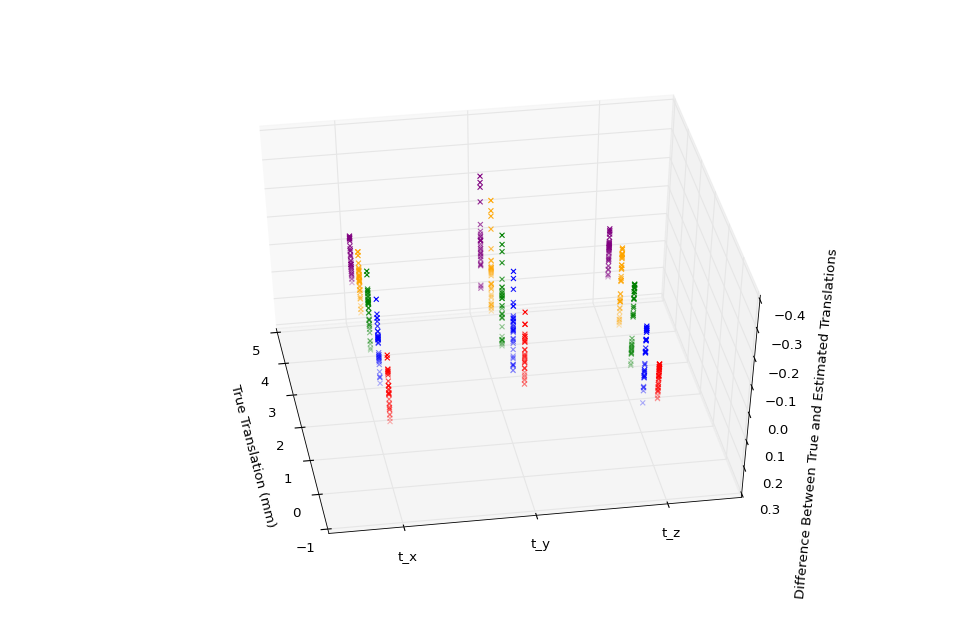

In [8]:
from IPython.html.widgets import interact

def plot_3D(diff_t, elev=30, azim=30):
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_subplot(111, projection='3d')
    n = 100
    for idx, (c, m) in enumerate([('r', 'x'), ('b', 'x'), ('g','x'),('orange', 'x'), ('purple', 'x')]):
        for i in xrange(3):
            zs = np.array(diff_t[idx])[:,i]
            ys = np.array([i]*len(zs))
            xs = np.array([idx]*len(zs))
            ax.scatter(xs, ys, zs, c=c, marker=m,lw=1)

    ax.set_xlabel('True Translation (mm)')
    y = [0,1,2]
    labels = ['t_x','t_y','t_z']
    ax.set_yticks(y)
    ax.set_yticklabels (labels, rotation='horizontal')
    ax.set_zlabel('Difference Between True and Estimated Translations')

#set azim to -77, elev to 24
def plotter(elev, azim):
    return plot_3D(diff_t, elev=elev, azim=azim)
interact(plotter, elev=[-30, 30], azim=(-180, 180));

<IPython.core.display.Javascript object>


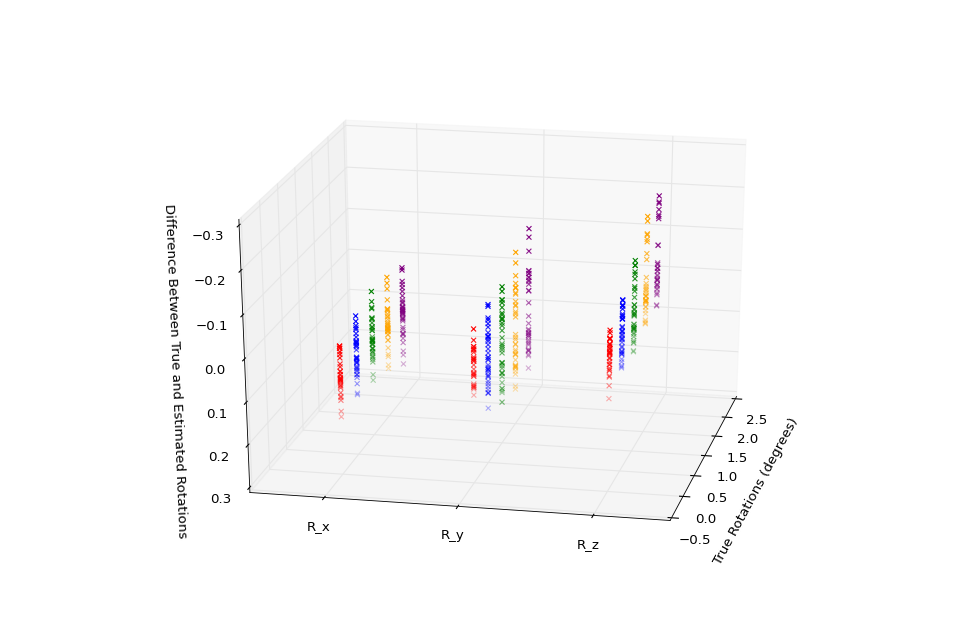

In [9]:
def plot_3D(diff_R, elev=30, azim=30):
    fig = plt.figure(figsize=[12,8])
    ax = fig.add_subplot(111, projection='3d')
    rs = np.arange(0,2.5,0.5)
    for idx, (c,m) in enumerate([('r', 'x'), ('b', 'x'), ('g','x'),('orange', 'x'), ('purple', 'x')]):
        for i in xrange(3):
            zs = np.array(diff_R[rs[idx]])[:,i]
            ys = np.array([i]*len(zs))
            xs = np.array([rs[idx]]*len(zs))
            ax.scatter(xs, ys, zs, c=c, marker=m,lw=1)

    ax.set_xlabel('True Rotations (degrees)')
    y = [0,1,2]
    labels = ['R_x','R_y','R_z']
    ax.set_yticks(y)
    ax.set_yticklabels (labels, rotation='horizontal')
    ax.set_zlabel('Difference Between True and Estimated Rotations')

#set azim to -77, elev to 24
def plotter(elev, azim):
    return plot_3D(diff_R, elev=elev, azim=azim)
interact(plotter, elev=[-30, 30], azim=(-180, 180));

## Rotations Only

In [10]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

0 1 2 3 4 5 6 7 8 9

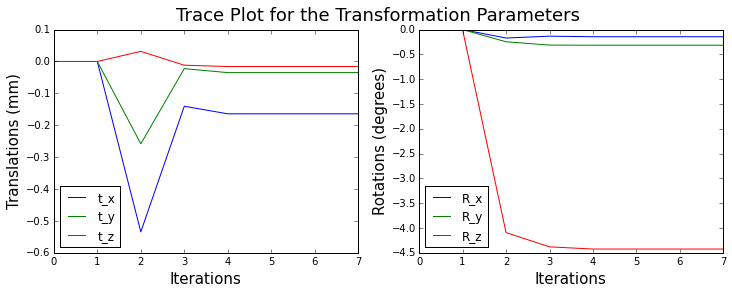

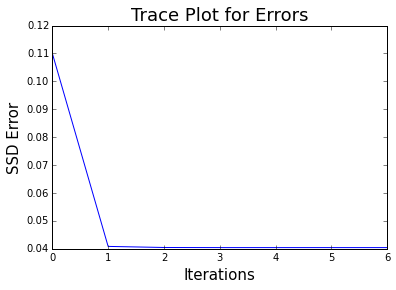

 min error:  0.0404338381349
parameters at min error:  [-0.02051564 -0.00435786 -0.0019722  -0.00251279 -0.00549226 -0.07721767]
translation (in mm): [-0.16412512 -0.03486285 -0.01577764]
rotations (in degrees): [-0.14397209 -0.31468357 -4.42424661]


In [13]:
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 Converged in 5 iterations!


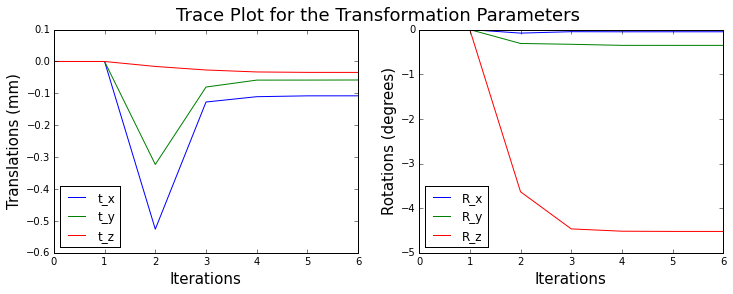

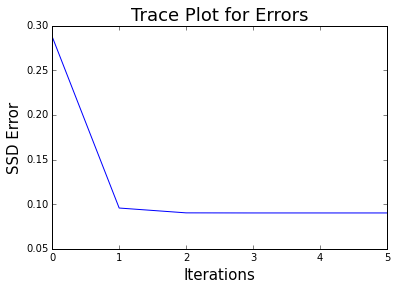

min error:  0.0901543783915
parameters at min error:  [-0.01682532 -0.00907047 -0.00535758 -0.00084876 -0.00617417 -0.07891597]
translation (in mm): [-0.10768208 -0.05805098 -0.03428853]
rotations (in degrees): [-0.04863026 -0.35375377 -4.52155198]


In [16]:
# Calculate the radius for masking
res = '6_4'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 Converged in 8 iterations!


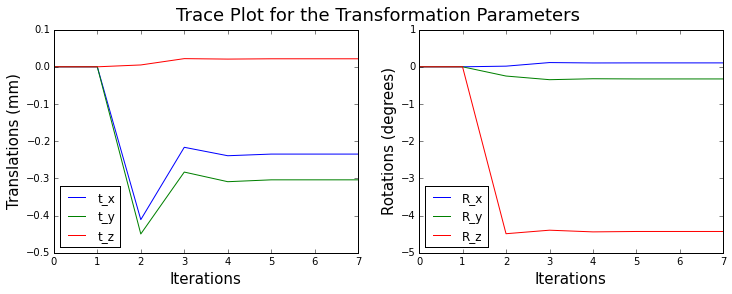

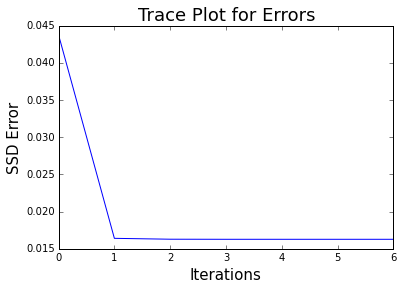

min error:  0.0162771738484
parameters at min error:  [-0.02346385 -0.0303861   0.00215334  0.00183601 -0.00569411 -0.07726247]
translation (in mm): [-0.23463852 -0.30386099  0.02153336]
rotations (in degrees): [ 0.10519538 -0.3262485  -4.42681362]


In [28]:
# Calculate the radius for masking
res = '10'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

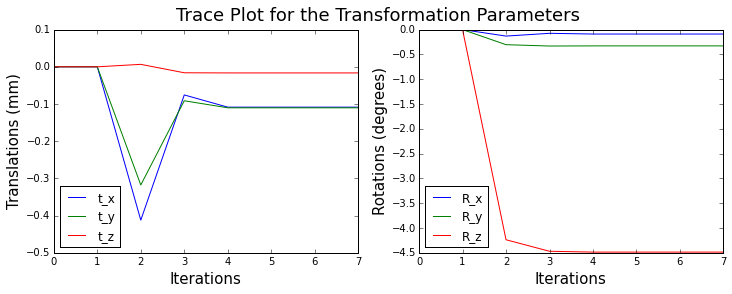

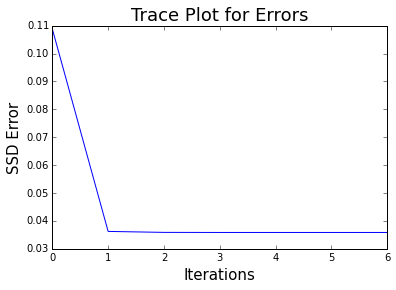

 min error:  0.0358556159653
parameters at min error:  [-0.01355964 -0.01377668 -0.0020568  -0.00156218 -0.00572998 -0.07829713]
translation (in mm): [-0.1084771  -0.11021345 -0.01645443]
rotations (in degrees): [-0.0895062  -0.32830369 -4.48609525]


In [29]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 Converged in 6 iterations!


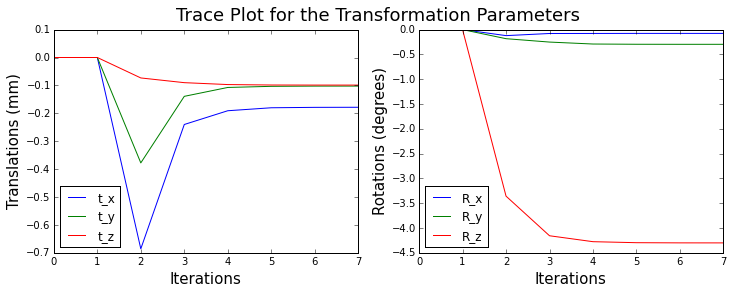

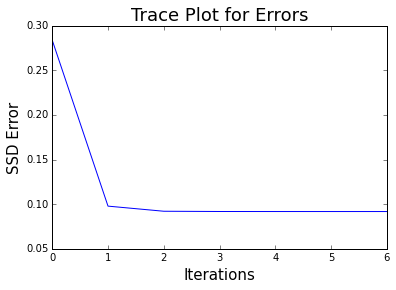

min error:  0.0917406799217
parameters at min error:  [-0.02787414 -0.01599996 -0.01545428 -0.00133316 -0.00517912 -0.07505496]
translation (in mm): [-0.17839449 -0.10239975 -0.0989074 ]
rotations (in degrees): [-0.07638461 -0.29674179 -4.30033244]


In [30]:
# Calculate the radius for masking
res = '6_4'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_6_4[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 Converged in 8 iterations!


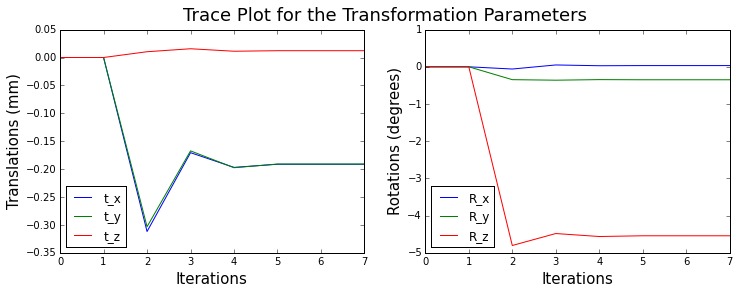

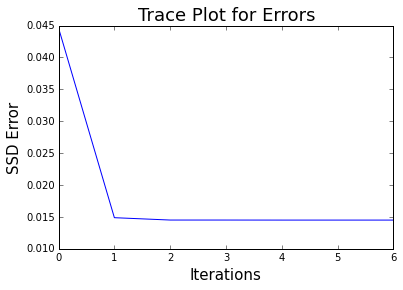

min error:  0.0145029208615
parameters at min error:  [-0.01912916 -0.01909073  0.00121835  0.00057183 -0.00608756 -0.07927727]
translation (in mm): [-0.19129163 -0.1909073   0.01218347]
rotations (in degrees): [ 0.03276327 -0.34879149 -4.5422527 ]


In [31]:
# Calculate the radius for masking
res = '10'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_10[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

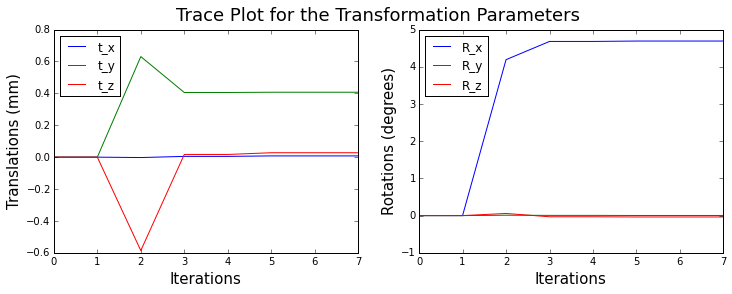

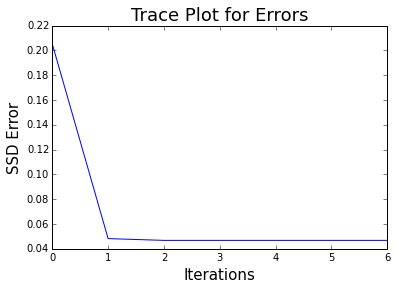

 min error:  0.0467907782387
parameters at min error:  [  9.65504297e-04   5.08918270e-02   3.45048548e-03   8.18976642e-02
   5.47411938e-05  -6.42153638e-04]
translation (in mm): [ 0.00772403  0.40713462  0.02760388]
rotations (in degrees): [  4.69239051e+00   3.13643937e-03  -3.67926932e-02]


In [32]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

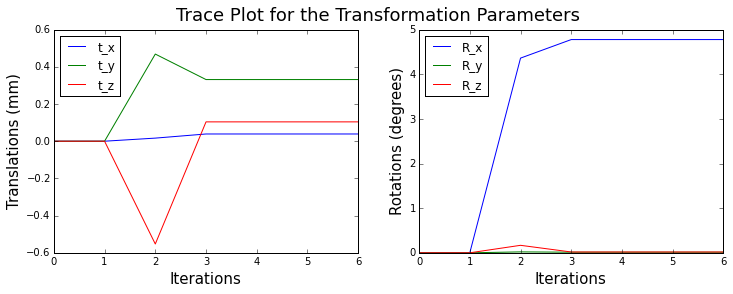

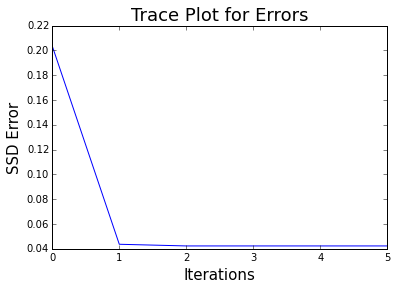

 min error:  0.0423125090181
parameters at min error:  [ 0.00485153  0.04142489  0.01299064  0.0833719   0.00023472  0.00031606]
translation (in mm): [ 0.03881222  0.33139908  0.10392509]
rotations (in degrees): [ 4.77685779  0.01344868  0.01810892]


In [33]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

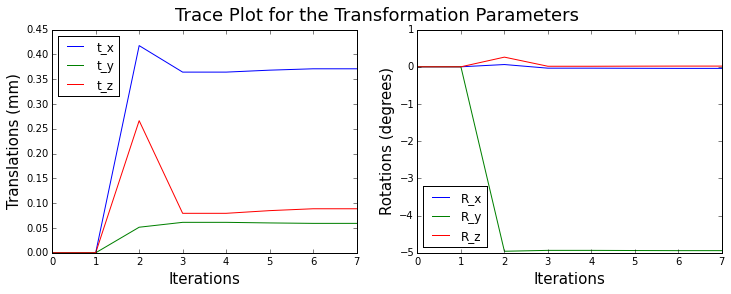

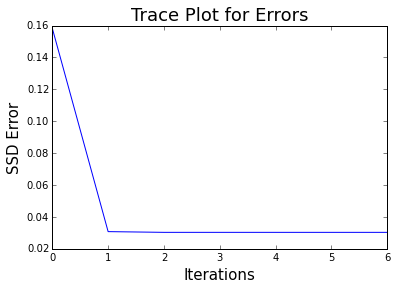

 min error:  0.0303170921069
parameters at min error:  [ 0.04637299  0.00741639  0.01109811 -0.00074248 -0.08625075  0.0003289 ]
translation (in mm): [ 0.37098395  0.05933111  0.08878491]
rotations (in degrees): [-0.04254102 -4.94180393  0.01884465]


In [34]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

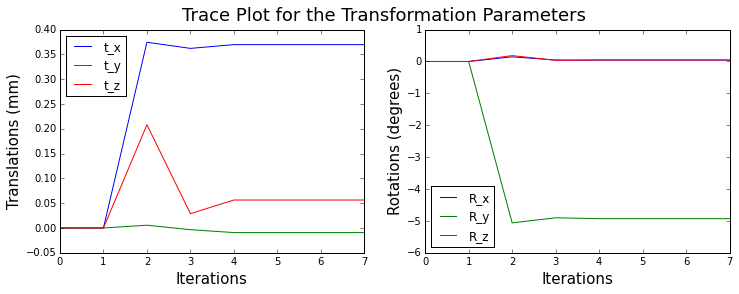

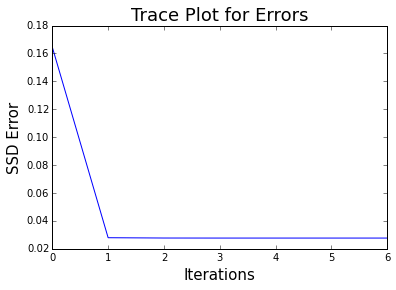

 min error:  0.0276967483995
parameters at min error:  [ 0.04621313 -0.00115521  0.00705458  0.00073401 -0.08603731  0.00084714]
translation (in mm): [ 0.36970505 -0.00924166  0.05643663]
rotations (in degrees): [ 0.04205558 -4.92957458  0.04853747]


In [35]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 5)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9 Converged in 9 iterations!


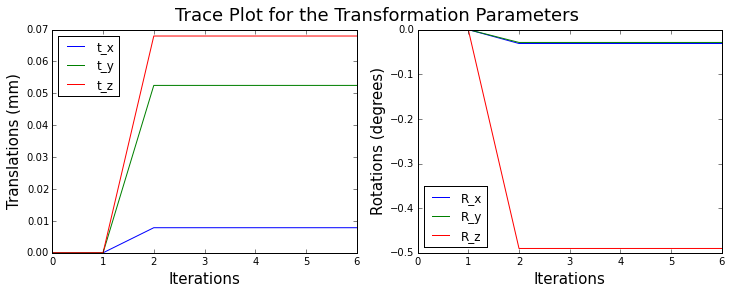

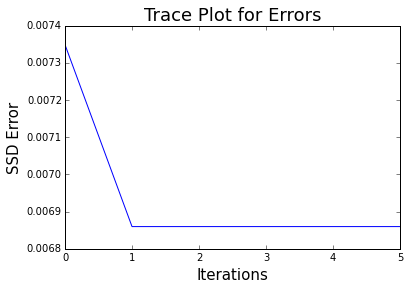

min error:  0.00685971257118
parameters at min error:  [ 0.00098347  0.00656207  0.00849843 -0.00054347 -0.00050249 -0.00855726]
translation (in mm): [ 0.00786773  0.05249659  0.06798745]
rotations (in degrees): [-0.03113878 -0.02879029 -0.49029474]


In [36]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 Converged in 7 iterations!


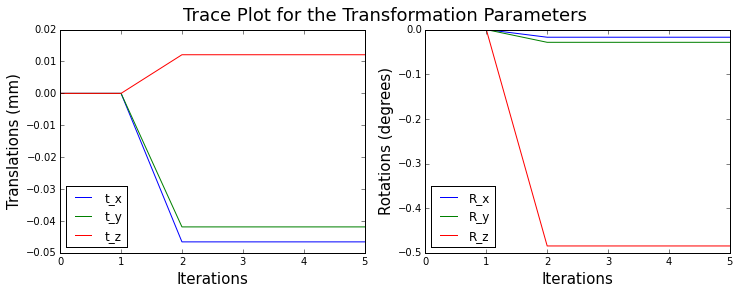

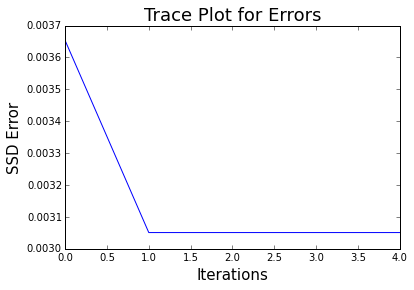

min error:  0.00305092092296
parameters at min error:  [-0.00582169 -0.00523476  0.00151431 -0.00029837 -0.00049702 -0.00845909]
translation (in mm): [-0.0465735  -0.04187807  0.01211447]
rotations (in degrees): [-0.01709515 -0.0284769  -0.48467044]


In [37]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 Converged in 5 iterations!


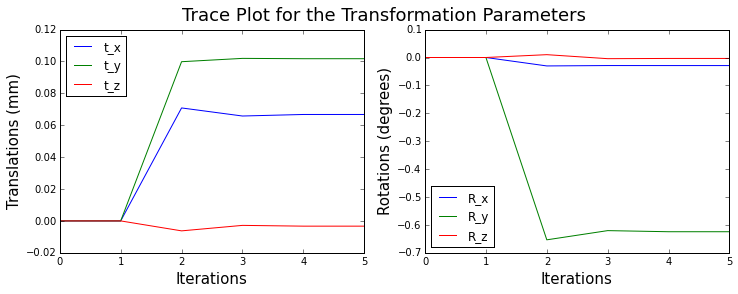

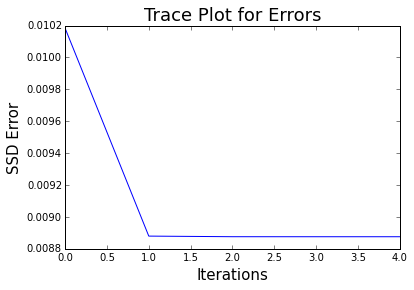

min error:  0.00887570668528
parameters at min error:  [  8.34545252e-03   1.27183173e-02  -4.10452264e-04  -5.04827766e-04
  -1.08989502e-02  -5.93093072e-05]
translation (in mm): [ 0.06676362  0.10174654 -0.00328362]
rotations (in degrees): [-0.0289245  -0.62446385 -0.00339817]


In [38]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 Converged in 5 iterations!


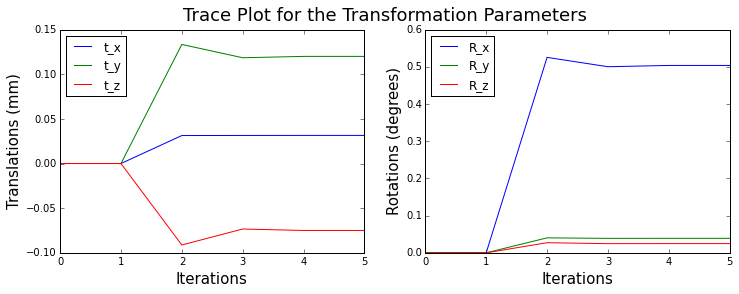

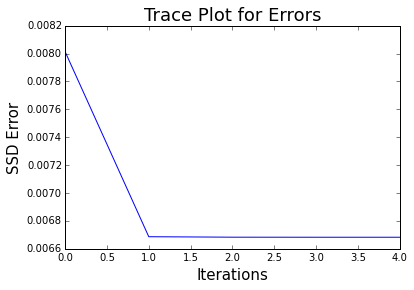

min error:  0.00668287392015
parameters at min error:  [ 0.00393581  0.01499885 -0.00937239  0.00879015  0.00067932  0.00043212]
translation (in mm): [ 0.03148646  0.11999082 -0.0749791 ]
rotations (in degrees): [ 0.50363855  0.03892227  0.0247584 ]


In [39]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.5, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

## Trough-plane rotation

In [40]:
from conversion import angles_from_q

0 1 2 3 4 5 6 7 8 9

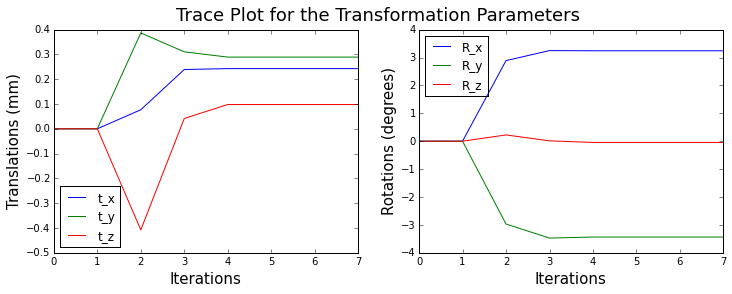

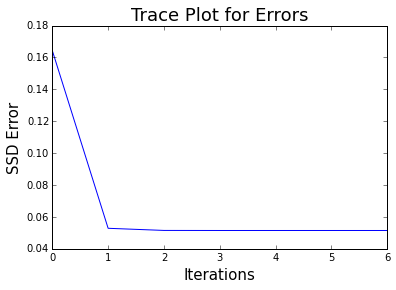

 min error:  0.0514834182633
parameters at min error:  [ 0.03032985  0.03613983  0.01223983  0.05656636 -0.05995391 -0.00077928]
translation (in mm): [ 0.24263877  0.2891186   0.09791861]
rotations (in degrees): [ 3.2410135  -3.43510594 -0.04464935]
Compare with Ground Truth:
3.53328719463 -3.54002475736 -0.109221547992


In [43]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'xy'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

# Get the angles from 5 degree rotation along xy
print 'Compare with Ground Truth:'
wx,wy,wz = ax_to_w(rot_ax)
beta, gamma, alpha = angles_from_q(5,wx,wy,wz)
print gamma, beta, alpha

0 1 2 3 4 5 6 7 8 9

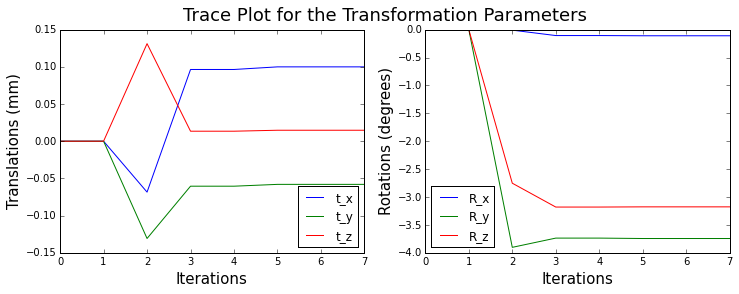

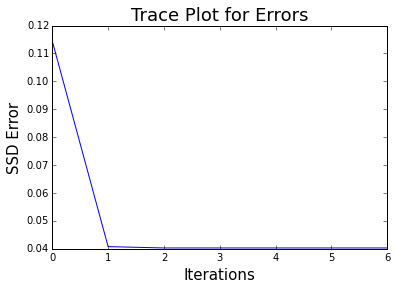

 min error:  0.0402997061219
parameters at min error:  [ 0.01248864 -0.0072526   0.001841   -0.00193012 -0.06534346 -0.05544374]
translation (in mm): [ 0.0999091  -0.05802077  0.01472798]
rotations (in degrees): [-0.11058778 -3.74390456 -3.17669221]
Compare with Ground Truth:
-0.109013935331 -3.53329359816 -3.53329359816


In [44]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'yz'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

# Get the angles from 5 degree rotation along xy
print 'Compare with Ground Truth:'
wx,wy,wz = ax_to_w(rot_ax)
beta, gamma, alpha = angles_from_q(5,wx,wy,wz)
print gamma, beta, alpha

0 1 2 3 4 5 6 7 8 9

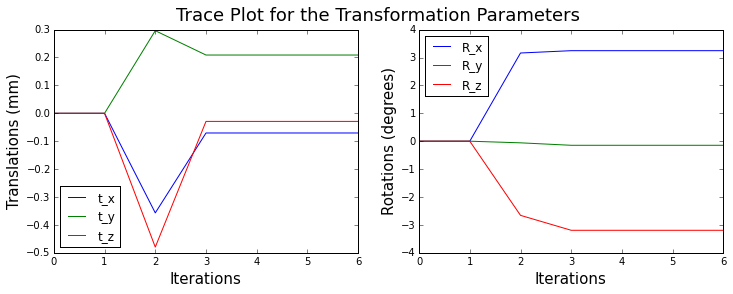

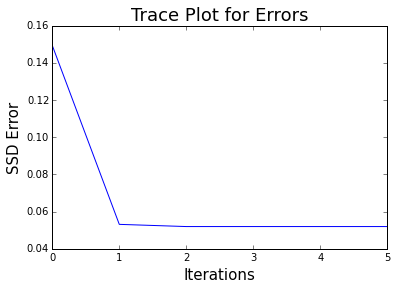

 min error:  0.0519591772712
parameters at min error:  [-0.00881851  0.02610652 -0.00363055  0.05662558 -0.00255891 -0.05573014]
translation (in mm): [-0.07054805  0.20885217 -0.02904437]
rotations (in degrees): [ 3.24440691 -0.14661475 -3.19310204]
Compare with Ground Truth:
3.53328719463 -0.109221547992 -3.54002475736


In [45]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'xz'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

# Get the angles from 5 degree rotation along xy
print 'Compare with Ground Truth:'
wx,wy,wz = ax_to_w(rot_ax)
beta, gamma, alpha = angles_from_q(5,wx,wy,wz)
print gamma, beta, alpha

# Translations Only

0 1 2 3 4 5 6 7 8 9

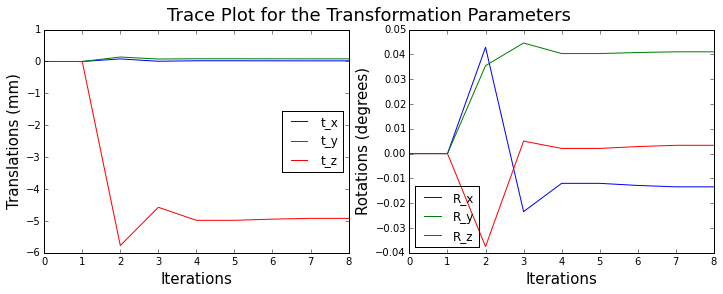

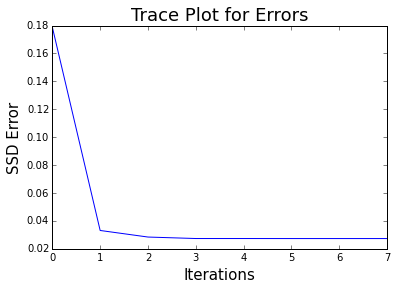

 min error:  0.0273432589117
parameters at min error:  [  2.47900057e-03   1.03489833e-02  -6.14969879e-01  -2.33881650e-04
   7.16340196e-04   5.84010831e-05]
translation (in mm): [ 0.019832    0.08279187 -4.91975904]
rotations (in degrees): [-0.01340043  0.04104327  0.00334614]


In [51]:
# Calculate the radius for masking
from Gauss_Newton import get_gradient_P,sphere_mask
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

In [95]:
### Large Translations
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'yz'

# Get two volumes to register
testVol1 = oct13_dict_5mm_trans['8mm']['yz']['xy'][ranges[0]][(0.0,0)]
testVol2 = oct13_dict_5mm_trans['8mm']['yz']['xy'][ranges[0]][(0.0,5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

In [96]:
s0,s1,s2 = testVol1.shape
volume_shape = testVol1.shape
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
ox = s1/2.-0.5
oy = s0/2.-0.5
oz = s2/2.-0.5

In [97]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    dest[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_masked)

1.91247221013


In [98]:
P_s = np.array([25./8.,-25./8.,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    dest[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_masked)

0.0161014816439


In [114]:
P_s = np.array([3,-3,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    dest[i,:,:] = tricubic_interp(volume_shape,vol2_dervs,dest_x[i,:,:],dest_y[i,:,:],dest_z[i,:,:]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_masked)

0.0265619181181


0 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
1 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
2 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
3 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
4 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
5 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
6 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
7 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
8 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]
9 1.57946679311 [ 0.94192667 -0.77161654  0.15367668  0.03881269  0.05799611 -0.00413007]


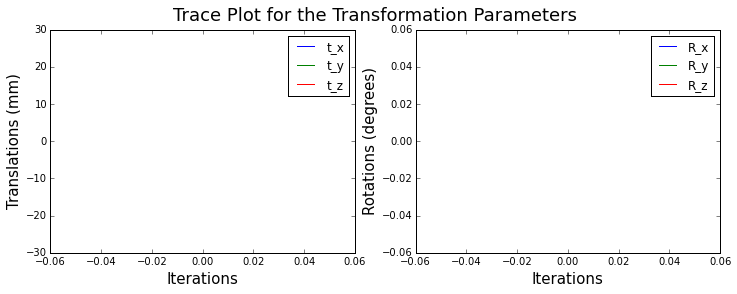

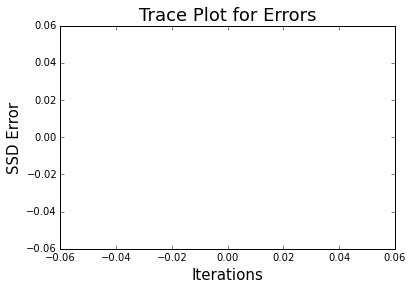

min error:  1.0
parameters at min error:  [ 3 -3  0  0  0  0]
translation (in mm): [ 24. -24.   0.]
rotations (in degrees): [ 0.  0.  0.]


In [121]:
P_s = np.array([3,-3,0,0,0,0])
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          P_initial = P_s, divide_factor = 1., alpha = 0.2, max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

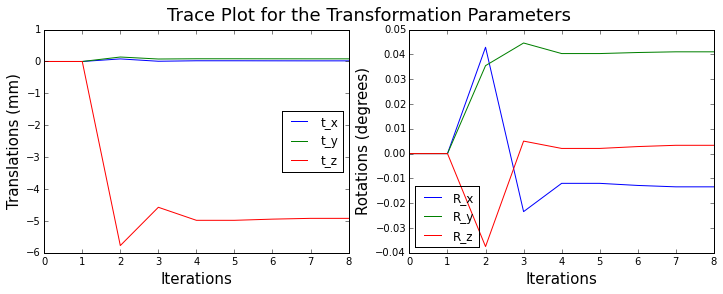

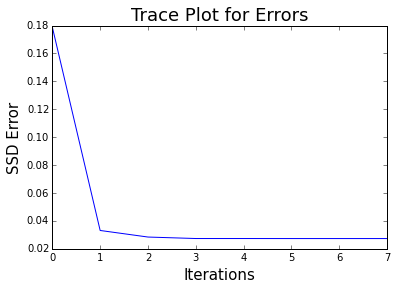

 min error:  0.027343268928
parameters at min error:  [  2.47884038e-03   1.03487000e-02  -6.14969916e-01  -2.33869618e-04
   7.16326121e-04   5.84127801e-05]
translation (in mm): [ 0.01983072  0.0827896  -4.91975932]
rotations (in degrees): [-0.01339974  0.04104246  0.00334681]


In [117]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

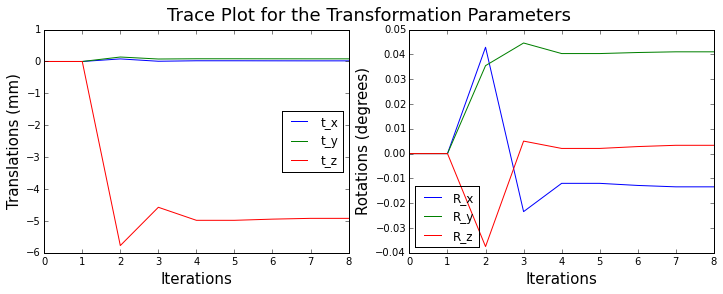

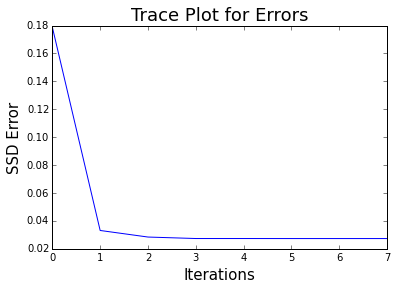

 min error:  0.027343268928
parameters at min error:  [  2.47884038e-03   1.03487000e-02  -6.14969916e-01  -2.33869618e-04
   7.16326121e-04   5.84127801e-05]
translation (in mm): [ 0.01983072  0.0827896  -4.91975932]
rotations (in degrees): [-0.01339974  0.04104246  0.00334681]


In [86]:
# Starting at solution
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

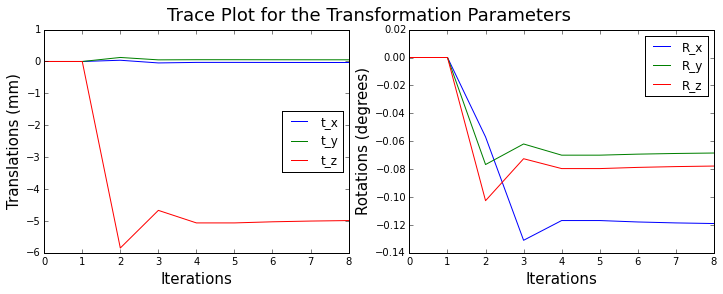

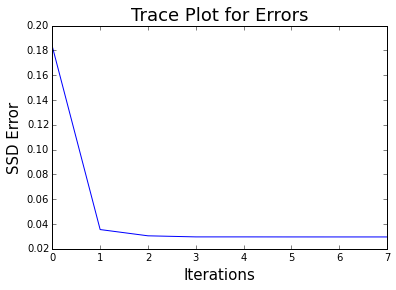

 min error:  0.0295639010173
parameters at min error:  [-0.00399988  0.00662161 -0.62364348 -0.00207727 -0.0011951  -0.00135817]
translation (in mm): [-0.03199902  0.05297286 -4.98914785]
rotations (in degrees): [-0.11901878 -0.06847432 -0.07781727]


In [87]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

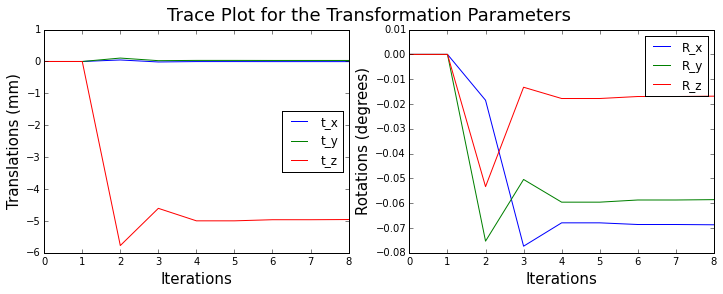

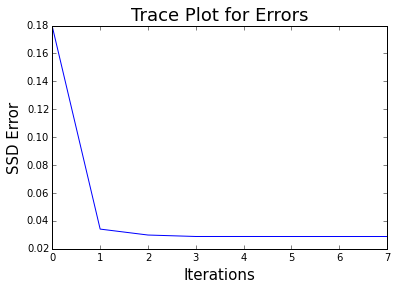

 min error:  0.0288124923709
parameters at min error:  [ -5.44410842e-04   4.02333904e-03  -6.19596558e-01  -1.19907422e-03
  -1.02212621e-03  -2.93984887e-04]
translation (in mm): [ -4.35528673e-03   3.21867123e-02  -4.95677246e+00]
rotations (in degrees): [-0.06870189 -0.05856352 -0.01684409]


In [88]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(0.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

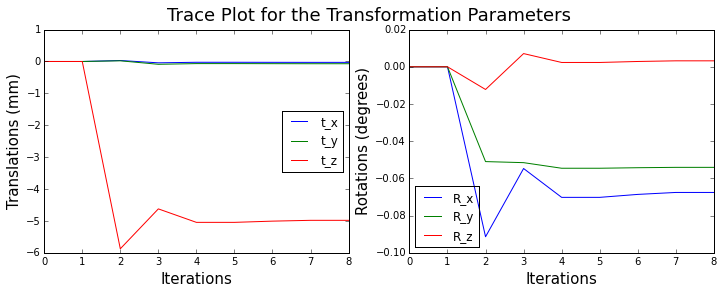

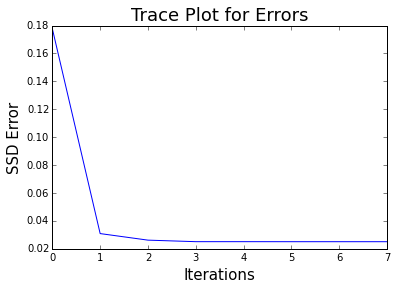

 min error:  0.0250909501431
parameters at min error:  [ -3.43345517e-03  -8.76695855e-03  -6.22704356e-01  -1.17903734e-03
  -9.43572696e-04   5.60862320e-05]
translation (in mm): [-0.02746764 -0.07013567 -4.98163485]
rotations (in degrees): [-0.06755386 -0.05406273  0.0032135 ]


In [89]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

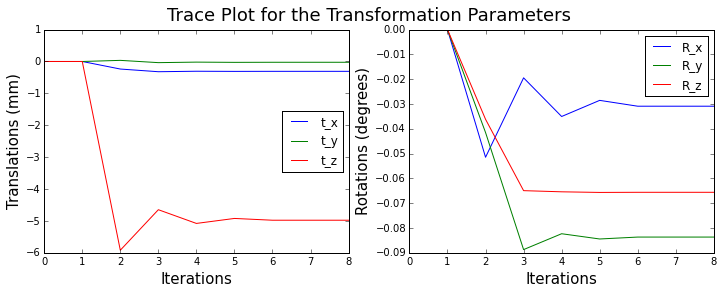

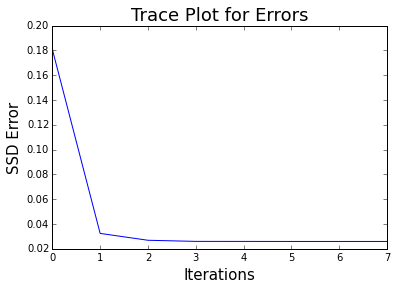

 min error:  0.0259181032176
parameters at min error:  [ -3.86026010e-02  -3.07583737e-03  -6.22287378e-01  -5.39137535e-04
  -1.46006729e-03  -1.14502394e-03]
translation (in mm): [-0.30882081 -0.0246067  -4.97829903]
rotations (in degrees): [-0.03089031 -0.08365569 -0.06560504]


In [90]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

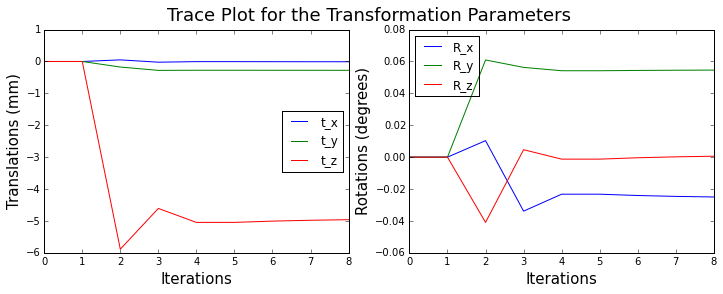

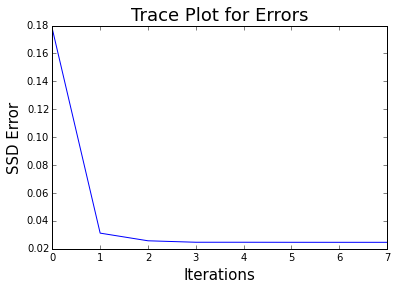

 min error:  0.0246465322324
parameters at min error:  [ -1.03170230e-03  -3.45906848e-02  -6.20245002e-01  -4.36014013e-04
   9.52940079e-04   1.01664207e-05]
translation (in mm): [-0.00825362 -0.27672548 -4.96196002]
rotations (in degrees): [-0.02498176  0.05459944  0.00058249]


In [91]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[0]][(2.5, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

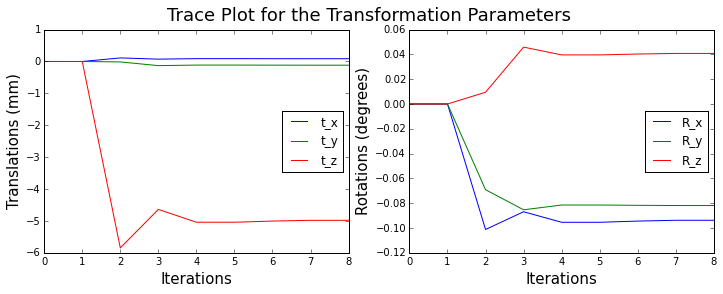

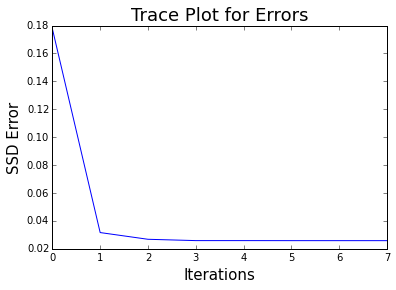

 min error:  0.0258440284986
parameters at min error:  [ 0.01082902 -0.01452253 -0.62265534 -0.00163671 -0.00142891  0.00071175]
translation (in mm): [ 0.08663215 -0.11618023 -4.98124272]
rotations (in degrees): [-0.09377635 -0.08187064  0.04078009]


In [92]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

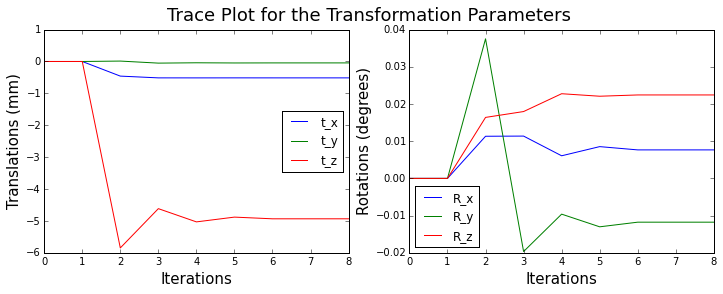

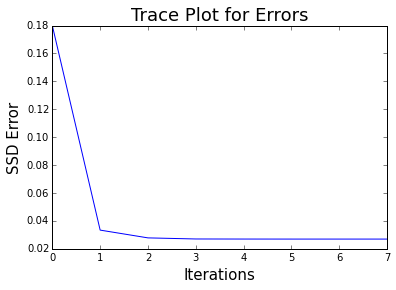

 min error:  0.0269678655702
parameters at min error:  [ -6.42551936e-02  -5.55452640e-03  -6.16731218e-01   1.33743184e-04
  -2.05380852e-04   3.91543750e-04]
translation (in mm): [-0.51404155 -0.04443621 -4.93384975]
rotations (in degrees): [ 0.00766292 -0.01176746  0.0224338 ]


In [93]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

0 1 2 3 4 5 6 7 8 9

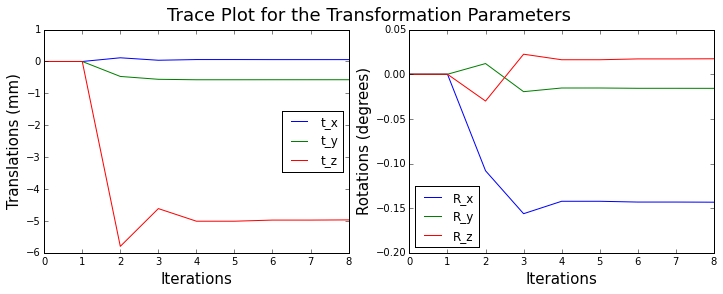

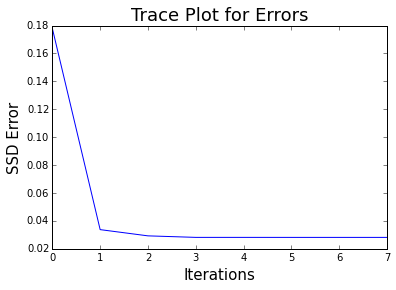

 min error:  0.0281754065351
parameters at min error:  [  7.28951742e-03  -7.15159601e-02  -6.21024851e-01  -2.50126721e-03
  -2.75729555e-04   3.02342981e-04]
translation (in mm): [ 0.05831614 -0.57212768 -4.96819881]
rotations (in degrees): [-0.14331205 -0.01579814  0.01732298]


In [94]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'x'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

In [11]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'xy'

# Get two volumes to register
testVol1 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = oct13_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 5)]

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

0 1 2 3 4 5 6 7 8 9

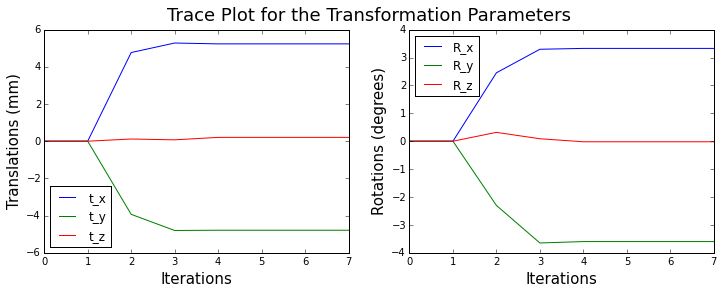

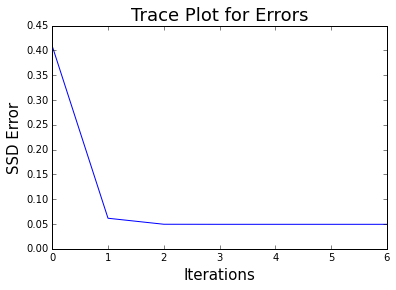

 min error:  0.049366481927
parameters at min error:  [  6.54083924e-01  -5.98328703e-01   2.56797151e-02   5.80503215e-02
  -6.27934726e-02  -3.57884067e-04]
translation (in mm): [ 5.23267139 -4.78662963  0.20543772]
rotations (in degrees): [ 3.32603842 -3.59780096 -0.02050525]
CPU times: user 2.01 s, sys: 40.7 ms, total: 2.05 s
Wall time: 2.08 s


In [12]:
%%time
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 16., alpha = 1., max_iter = 10, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

In [14]:
from conversion import angles_from_q
print 'Compare with Ground Truth:'
wx,wy,wz = ax_to_w(rot_ax)
beta, gamma, alpha = angles_from_q(5,wx,wy,wz)
print gamma, beta, alpha

Compare with Ground Truth:
3.53328719463 -3.54002475736 -0.109221547992


In [120]:
from Gauss_Newton import to_degree
def trace_plot(Ps,res,true_Ps):
    arr = np.array(Ps)
    true_arr = np.array(true_Ps)
    plt.figure(figsize = [12,4])
    plt.subplot(1,2,1)
    t_legends = ['x','y','z']
    colors = ['blue','red','green']
    for i in xrange(3):
        plt.plot(arr[:,i]*res,color = colors[i],label = 't_%s'%t_legends[i])
        plt.hlines(true_arr[i],0,len(Ps)-1,linestyles='dashed',color = colors[i],label = 'true t_%s'%t_legends[i])
    plt.legend(loc = 'best')
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Translations (mm)', fontsize = 15)
    plt.subplot(1,2,2)
    R_legends = ['x','y','z']
    for j in xrange(3,6):
        plt.plot(to_degree(arr[:,j]),label = 'R_%s'%R_legends[j-3])
        plt.hlines(true_arr[j],0,len(Ps)-1,linestyles='dashed',color = colors[j-3],label = 'true R_%s'%t_legends[j-3])
    plt.legend(loc = 'best')
    plt.suptitle('Trace Plot for the Transformation Parameters',fontsize=18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Rotations (degrees)', fontsize = 15)
    plt.show()
    
def plot_errors(errors):
    plt.plot(errors[1:])
    plt.title('Trace Plot for Errors',fontsize = 18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('SSD Error', fontsize = 15)
    plt.show()

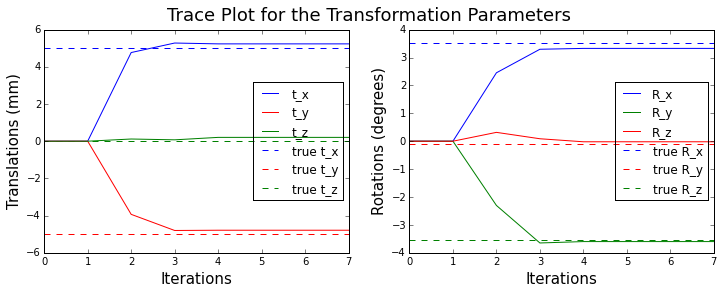

In [67]:
trace_plot(Ps,8,[5,-5,0,gamma, alpha, beta])